In [1]:
import subprocess
import matplotlib.pyplot as plt
import os
from constants import OPENAI_API_KEY, BITWIDTH
from pathlib import Path
from parse_functions import get_pareto_points, get_points

### Генерируем все возможные деревья

In [8]:
folders = [f'bitwidth_{BITWIDTH}', f'bitwidth_{BITWIDTH}_output']

for folder in folders:
    if os.path.exists(folder):
        subprocess.run(f"rm -rf {folder}", shell=True, check=True)

In [3]:
subprocess.run(["python3", "0_generate_prefix_trees_code.py"], check=True)

bitwidth 5, number of matrices 64
43


CompletedProcess(args=['python3', '0_generate_prefix_trees_code.py'], returncode=0)

### Проверяем их

In [ ]:
subprocess.run(["python3", "1_check_input_files.py"], check=True)

### Генерируем параметры

In [ ]:
subprocess.run(["python3", "2_generate_params.py"], check=True)

### Запускаем синтез

In [ ]:
subprocess.run(f"export BIT_WIDTH={BITWIDTH} && yosys 3_run_synthesis.tcl", shell=True, check=True)

### Получаем значения площади и задержки

In [ ]:
subprocess.run(["python3", "4_get_delay_sta.py"], check=True)

### Строим графики

bitwidth_6_output


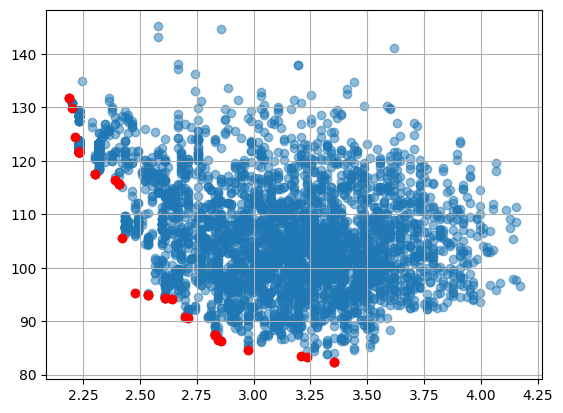

In [2]:
res_dir = f'bitwidth_{BITWIDTH}_output'
df = get_points(res_dir)
print(res_dir)
pareto_front = get_pareto_points(df)

plt.scatter(df.area, df.delay, alpha=0.5)
plt.scatter(pareto_front.area, pareto_front.delay, c='r')
plt.grid()

### Очищаем папки и запускаем LLM-генератор

In [3]:
out_dir = f'llm_bitwidth_{BITWIDTH}'
Path(out_dir).mkdir(parents=True, exist_ok=True)
Path(f'{out_dir}_output').mkdir(parents=True, exist_ok=True)
subprocess.run(f'rm -rf {out_dir}/* {out_dir}_output/*', shell=True, check=True)

CompletedProcess(args='rm -rf llm_bitwidth_6/* llm_bitwidth_6_output/*', returncode=0)

In [4]:
subprocess.run(["python3", "llm_generator.py"], check=True)


Iteration 1
Lacking bit ranges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Sending request to LLM...
LLM response:
6: connectedNodes=(0, 1), range=[0:1], left_bound=0, right_bound=1.
7: connectedNodes=(6, 2), range=[0:2], left_bound=0, right_bound=2.
8: connectedNodes=(7, 3), range=[0:3], left_bound=0, right_bound=3.
9: connectedNodes=(8, 4), range=[0:4], left_bound=0, right_bound=4.
10: connectedNodes=(9, 5), range=[0:5], left_bound=0, right_bound=5.
New nodes received: 5

Iteration 2
SPCR is valid, synthesis completed.


CompletedProcess(args=['python3', 'llm_generator.py'], returncode=0)

### Проверяем структуру

In [8]:
subprocess.run(["python3", "1_check_input_files.py", "llm_bitwidth"], check=True)

llm_bitwidth_2
Correct all 0 files
llm_bitwidth_3
Correct all 0 files
llm_bitwidth_4
Correct all 0 files
llm_bitwidth_5
Correct all 0 files
llm_bitwidth_6
Correct all 1 files


CompletedProcess(args=['python3', '1_check_input_files.py', 'llm_bitwidth'], returncode=0)

### Запускаем синтез

In [ ]:
subprocess.run(f"export BIT_WIDTH={out_dir} && yosys 3_run_synthesis.tcl", shell=True, check=True)

### Получаем площадь и задержку

In [ ]:
subprocess.run(["python3", "4_get_delay_sta.py", "llm_bitwidth"], check=True)

### Строим графики (красные точки - Парето-Фронт для LLM-сумматора, зеленые - для прошлых)

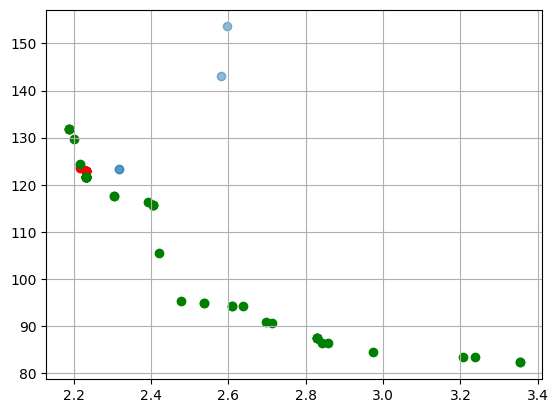

In [11]:
res_dir = f'{out_dir}_output'
df_llm = get_points(res_dir)

pareto_front_llm = get_pareto_points(df_llm)

plt.scatter(df_llm.area, df_llm.delay, alpha=0.5)
plt.scatter(pareto_front_llm.area, pareto_front_llm.delay, c='r')
plt.scatter(pareto_front.area, pareto_front.delay, c='g')
plt.grid()

#### Синтез всех возможных деревьев для n=6 занимает около 40 минут. Весь процесс генерации и синтеза с помощью LLM занимает около 1 минуты. 